# **DATA Exploration**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datadir='/content/drive/MyDrive/kvasir-dataset-v2'
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

number of categories:  8


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,categorie,numbre of files
0,dyed-lifted-polyps,1000
1,dyed-resection-margins,1000
2,esophagitis,1000
3,normal-cecum,1000
4,normal-pylorus,1000
5,normal-z-line,1000
6,polyps,1000
7,ulcerative-colitis,1000


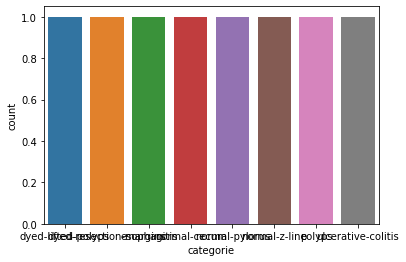

In [ ]:
import seaborn as sns
dataset_dir = "/content/drive/MyDrive/kvasir-dataset-v2" 
def get_dataCategories(dataset_dir):
    """
        optenire les categories (classe) du dataset a partire du chemin du dataset 
        en question.

    Args:
        dataset_dir (str): chemin du dataset

    Returns:
        list: liste des categories
        list: liste des nombre de fichier par categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])



categories, nbr_files = get_dataCategories(dataset_dir)
# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
sns.countplot(df['categorie'],label='count')
df

In [ ]:
training_data=[]
def create_training_data():
    for category in categories:
        path = os.path.join(datadir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(224,224))
                training_data.append([new_array,class_num])
            except Exception as e:    
                pass
create_training_data() 

In [ ]:
x=[]
y=[]
for features,label in training_data:
    x.append(features)
    y.append(label)
x = np.array(x)
x.shape

(8000, 224, 224, 3)

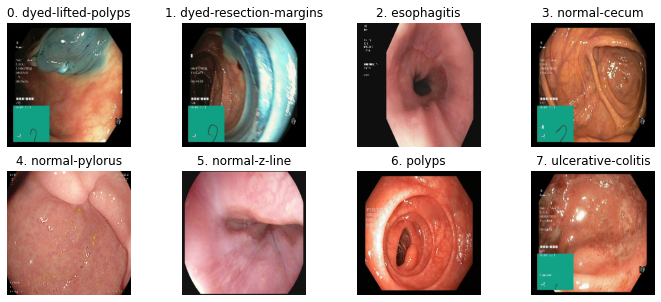

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 1000
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

# **DATA Modelling**

##**VGG**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)
y_val = tf.keras.utils.to_categorical(y_val, 8)

In [ ]:
print(f"X_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (4480, 224, 224, 3)
y_train: (4480, 8)
X_test: (1600, 224, 224, 3)
y_test: (1600, 8)


In [ ]:
# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},  y_test:{y_test.shape}")

x_train:(4480, 224, 224, 3),  y_train:(4480, 8)
x_val:(1920, 224, 224, 3),  y_val:(1920, 8)
x_test:(1600, 224, 224, 3),  y_test:(1600, 8)


In [ ]:
from keras.models import load_model
#model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))
#iif it's already created and saved --> load the model
if os.path.isfile("./saved_model/vgg16_model.h5"):
  # load model
  base_model = load_model("./saved_model/vgg16_model.h5")
    
# if not already created --> created and save the model
else:
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        pooling="avg",
        input_shape=(224, 224, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg16_model.h5")

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x =  tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x)   
model_final = tf.keras.models.Model(base_model.input,predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
if os.path.isfile("./saved_model/modelvgg.h5"):
    model = load_model("./saved_model/modelvgg.h5")

    if os.path.isfile("./saved_model/modelvgg_history.npy"):

        history = np.load("./saved_model/modelvgg_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

else:
    history=model_final.fit(x_train, y_train,
          batch_size=55,
          epochs=50,
          verbose=1,validation_data=(x_val, y_val))
    history = history.history

    # save model
    np.save("/content/drive/MyDrive/model_vgg_history.npy", history)
    model_final.save("/content/drive/MyDrive/model_vgg.h5")

'''history=model_final.fit(x_train, y_train,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(x_val, y_val))'''

Epoch 1/50
82/82 [==============================] - 42s 463ms/step - loss: 1.7540 - accuracy: 0.4605 - val_loss: 0.9195 - val_accuracy: 0.6635
Epoch 2/50
82/82 [==============================] - 32s 387ms/step - loss: 0.7433 - accuracy: 0.7301 - val_loss: 0.6905 - val_accuracy: 0.7323
Epoch 3/50
82/82 [==============================] - 31s 384ms/step - loss: 0.5939 - accuracy: 0.7806 - val_loss: 0.6238 - val_accuracy: 0.7526
Epoch 4/50
82/82 [==============================] - 32s 386ms/step - loss: 0.5172 - accuracy: 0.8105 - val_loss: 0.5503 - val_accuracy: 0.7854
Epoch 5/50
82/82 [==============================] - 32s 386ms/step - loss: 0.4637 - accuracy: 0.8272 - val_loss: 0.5096 - val_accuracy: 0.8047
Epoch 6/50
82/82 [==============================] - 31s 386ms/step - loss: 0.4293 - accuracy: 0.8411 - val_loss: 0.4930 - val_accuracy: 0.7911
Epoch 7/50
82/82 [==============================] - 31s 385ms/step - loss: 0.3993 - accuracy: 0.8509 - val_loss: 0.4701 - val_accuracy: 0.8172

'history=model_final.fit(x_train, y_train,\n          batch_size=64,\n          epochs=50,\n          verbose=1,\n          validation_data=(x_val, y_val))'

In [ ]:
score = model_final.evaluate(x_test, y_test, verbose=0)

In [ ]:

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4047611355781555
Test accuracy: 0.8374999761581421


In [ ]:
predictions=model_final.predict(x_test)
predictions[9]
import numpy as np
np.argmax(predictions[0])

50/50 [==============================] - 7s 146ms/step


4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


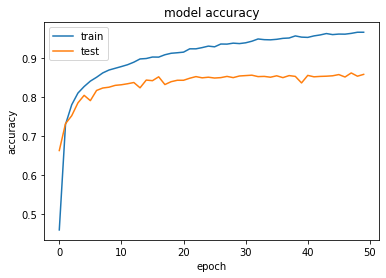

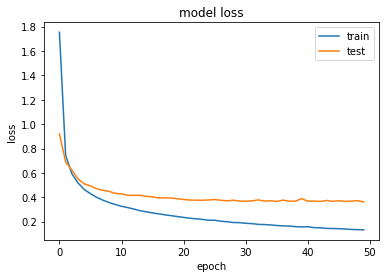

In [ ]:
print(history.keys())

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )



In [ ]:
from sklearn.metrics import confusion_matrix

50/50 [==============================] - 7s 147ms/step


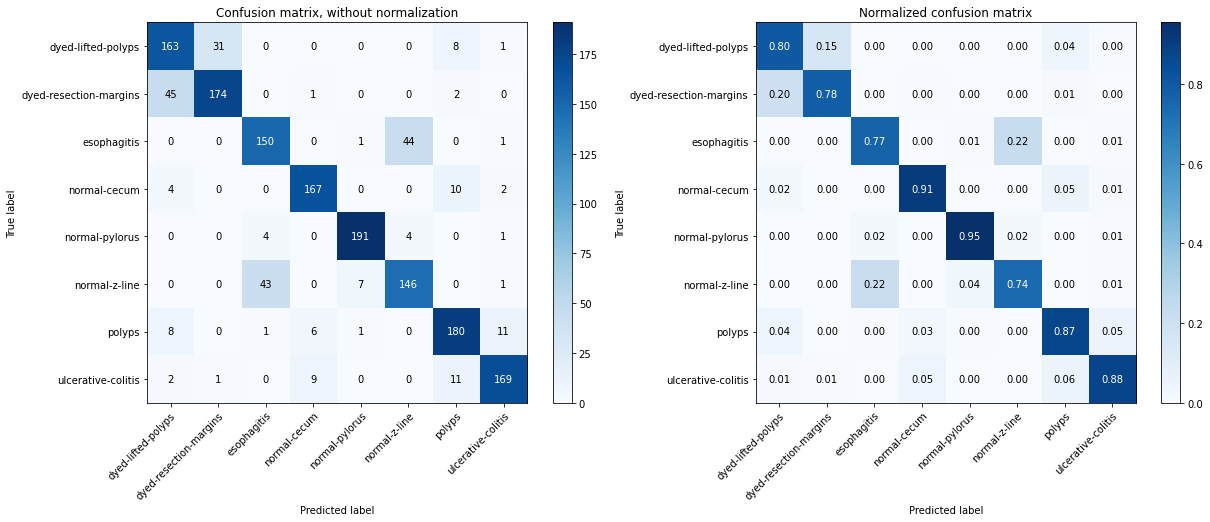

In [ ]:
# Making prediction
y_pred = np.argmax(model_final.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

##**RESNET**

In [ ]:
from tensorflow.keras.applications import ResNet50
import keras

In [ ]:
from keras.models import load_model
#model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))
if os.path.isfile("./saved_model/resnet_model.h5"):
  # load model
  base_model = load_model("./saved_model/resnet_model.h5")
    
else:
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        pooling="avg",
        input_shape=(224, 224, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/resnet_model.h5")

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from keras.models.cloning import Sequential
for layer in base_model.layers:
    layer.trainable = False
renet_model=Sequential()
renet_model.add(base_model)
renet_model.add(Flatten())
renet_model.add(Dense(1024, activation='relu'))
renet_model.add(Dense(512, activation='relu'))
renet_model.add(Dense(256, activation='relu'))
renet_model.add(Dense(8, activation='softmax'))

'x = base_model.output\nx =  tf.keras.layers.Flatten()(x)\nx = tf.keras.layers.Dense(505, activation="relu")(x)\nx = tf.keras.layers.Dropout(0.5)(x)\nx = tf.keras.layers.Dense(505, activation="relu")(x)\npredictions = tf.keras.layers.Dense(8, activation="softmax")(x)   \nmodel_final = tf.keras.models.Model(base_model.input,predictions)\nmodel_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"]).'

In [ ]:
renet_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
if os.path.isfile("./saved_model/resnetmodel.h5"):

    model = load_model("./saved_model/resnetmodel.h5")

    if os.path.isfile("./saved_model/resnethistory.npy"):
        history = np.load("./saved_model/resnethistory.npy", allow_pickle="TRUE").item()
    else:
        history = None

else:
    history=renet_model.fit(x_train, y_train,
          batch_size=55,
          epochs=50,
          verbose=1,validation_data=(x_val, y_val))
    history = history.history

    # save model
    np.save("/content/drive/MyDrive/resnet_history.npy", history)
    renet_model.save("/content/drive/MyDrive/resnet_model.h5")

Epoch 1/50
82/82 [==============================] - 18s 219ms/step - loss: 0.2450 - accuracy: 0.9154 - val_loss: 0.3176 - val_accuracy: 0.8740
Epoch 2/50
82/82 [==============================] - 18s 218ms/step - loss: 0.2443 - accuracy: 0.9141 - val_loss: 0.3216 - val_accuracy: 0.8734
Epoch 3/50
82/82 [==============================] - 18s 221ms/step - loss: 0.2428 - accuracy: 0.9129 - val_loss: 0.3214 - val_accuracy: 0.8682
Epoch 4/50
82/82 [==============================] - 18s 223ms/step - loss: 0.2392 - accuracy: 0.9174 - val_loss: 0.3140 - val_accuracy: 0.8776
Epoch 5/50
82/82 [==============================] - 18s 223ms/step - loss: 0.2371 - accuracy: 0.9190 - val_loss: 0.3155 - val_accuracy: 0.8776
Epoch 6/50
82/82 [==============================] - 18s 222ms/step - loss: 0.2352 - accuracy: 0.9167 - val_loss: 0.3175 - val_accuracy: 0.8703
Epoch 7/50
82/82 [==============================] - 18s 222ms/step - loss: 0.2332 - accuracy: 0.9232 - val_loss: 0.3157 - val_accuracy: 0.8760

OSError: ignored

In [ ]:
np.save("/content/drive/MyDrive/resnethistory.npy", history)
renet_model.save("/content/drive/MyDrive/resnetmodel.h5")

In [ ]:
from keras.models import load_model
model=load_model('/content/drive/MyDrive/resnetmodel.h5')

In [ ]:
scor = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scor[0])
print('Test accuracy:', scor[1])

Test loss: 0.3114357888698578
Test accuracy: 0.8756250143051147


In [ ]:
predictions=model.predict(x_test)
predictions[0]
import numpy as np
np.argmax(predictions[0])

50/50 [==============================] - 5s 87ms/step


5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


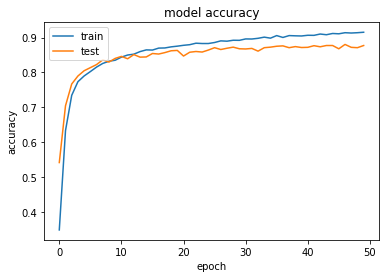

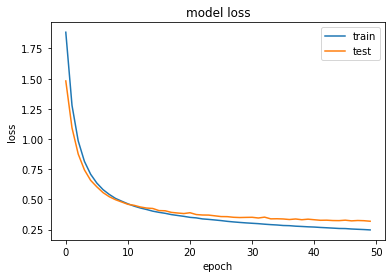

In [ ]:
print(history.keys())

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

50/50 [==============================] - 4s 87ms/step


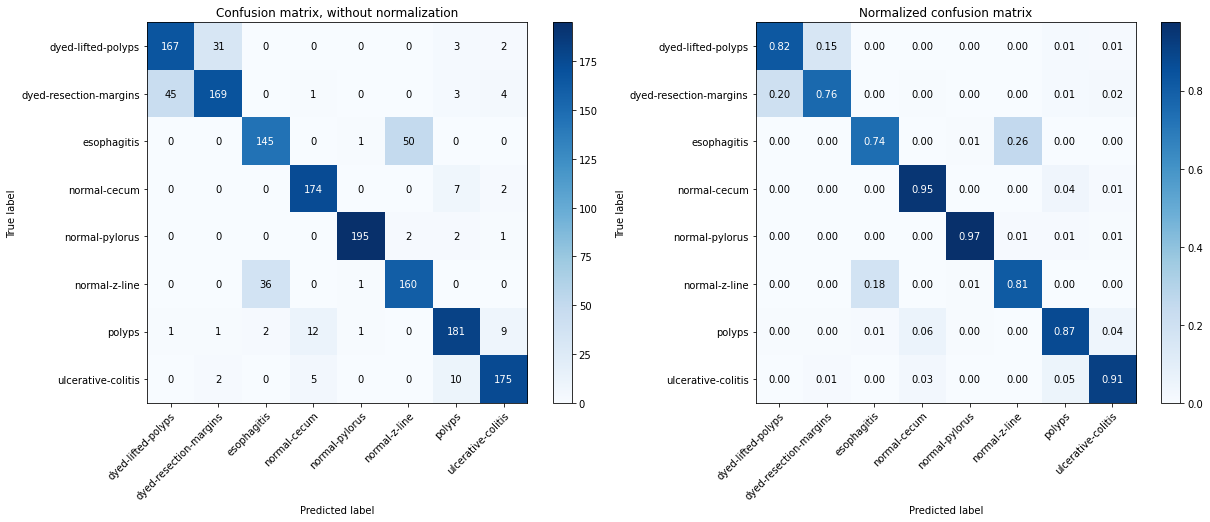

In [ ]:

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )
from sklearn.metrics import confusion_matrix
# Making prediction
y_pred = np.argmax(renet_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

## **ViT**

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.6 MB/s eta 0:00:00


In [ ]:
!pip install --quiet vit-keras

from vit_keras import vit

  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')

In [ ]:
IMAGE_SIZE = 224
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 8)

353253686/353253686 [==============================] - 65s 0us/step


In [ ]:
for layer in vit_model.layers:
    layer.trainable = False
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(8, 'softmax')
    ],
    name = 'vision_transformer')


model.summary()




Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 88,254,984
Trainable params: 797,704
Non-trainable params: 87,457,280
______________________________

In [ ]:
learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), metrics = ['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2,patience = 2,verbose = 1,min_delta = 1e-4,min_lr = 1e-6, mode = 'max')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-4,patience = 5,mode = 'max',restore_best_weights = True, verbose = 1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5', monitor = 'val_accuracy', verbose = 1,save_best_only = True,save_weights_only = True,mode = 'max')
callbacks = [earlystopping, reduce_lr, checkpointer]

In [ ]:
history=model.fit(x_train,y_train,
          validation_data =(x_val,y_val),
          epochs = 20,
          batch_size=44,
          callbacks = callbacks)


Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 2.1956 - accuracy: 0.2661
Epoch 1: val_accuracy improved from -inf to 0.46510, saving model to ./model.hdf5
102/102 [==============================] - 63s 315ms/step - loss: 2.1956 - accuracy: 0.2661 - val_loss: 1.6333 - val_accuracy: 0.4651 - lr: 1.0000e-04
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 1.6423 - accuracy: 0.5136
Epoch 2: val_accuracy improved from 0.46510 to 0.54271, saving model to ./model.hdf5
102/102 [==============================] - 27s 270ms/step - loss: 1.6423 - accuracy: 0.5136 - val_loss: 1.4872 - val_accuracy: 0.5427 - lr: 1.0000e-04
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 1.5440 - accuracy: 0.5609
Epoch 3: val_accuracy improved from 0.54271 to 0.63594, saving model to ./model.hdf5
102/102 [==============================] - 27s 269ms/step - loss: 1.5440 - accuracy: 0.5609 - val_loss: 1.3643 - val_accuracy: 0.6359 - lr: 1.0000e-04
Epoch 4

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.271525502204895
Test accuracy: 0.7281249761581421


In [ ]:
np.save("/content/drive/MyDrive/vit_history.npy", history)
model.save("/content/drive/MyDrive/vit_model.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


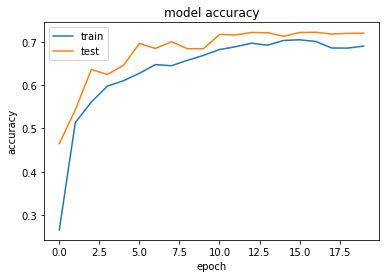

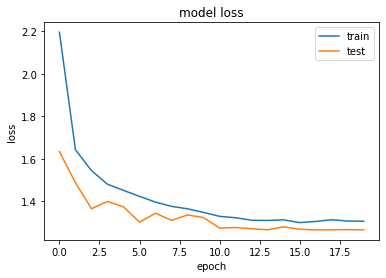

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

50/50 [==============================] - 7s 106ms/step


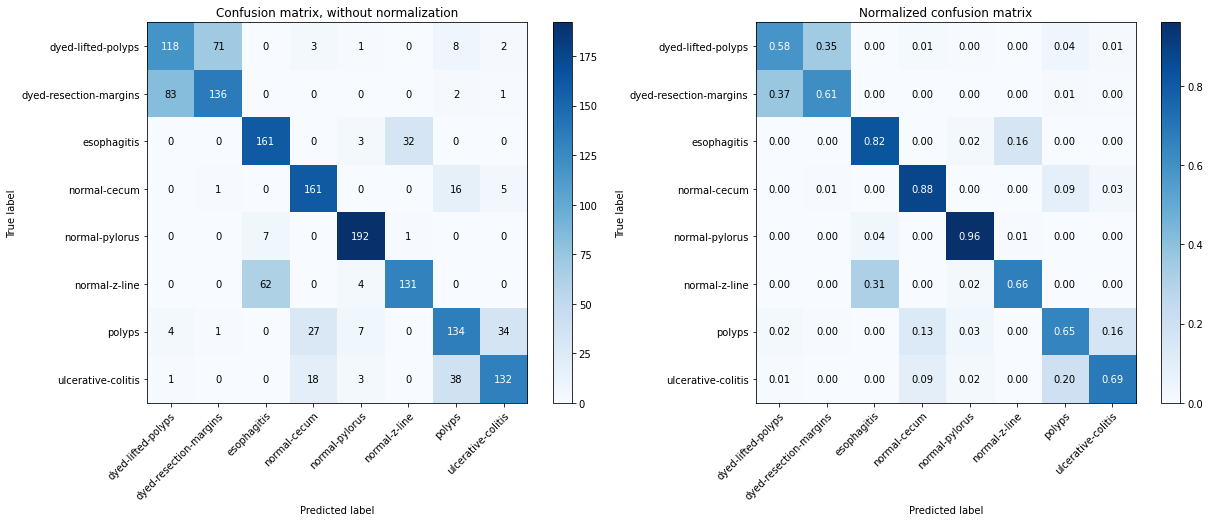

In [ ]:

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )
from sklearn.metrics import confusion_matrix
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# get confusion matrix
vit_confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(vit_confuision_mat, classes=categories, fig_size=(20, 7))